## Sarscam Classifier


In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Defining the variables:
1. dictionary size
2. embedding size
3. max length of a single input
4. truncating type
5. padding type
6. token for words not in vocabulary
7. defining the size of the train set and remaining will be the test set.

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length =  90
truc_type ='post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

Downloading the dataset.... from kaggel

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2020-07-01 06:09:17--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.04s   

2020-07-01 06:09:17 (138 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



Splitting the data into two parts "sentences" and "labels"

In [4]:
with open('/tmp/sarcasm.json','r') as f:
  datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

In [5]:
import pandas as pd
pd.DataFrame(labels,sentences,).head()

,0
former versace store clerk sues over secret 'black code' for minority shoppers,0
"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
mom starting to fear son's web series closest thing she will have to grandchild,1
"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
j.k. rowling wishes snape happy birthday in the most magical way,0


Splitting the data in training and testing sets

In [6]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

Creating token for the words in the sequences.

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                                padding=padding_type,truncating= truc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                                padding=padding_type,truncating= truc_type)

In [8]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [9]:
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])

def decode_sentence(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [10]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 90, 16)            160000    
_________________________________________________________________
flatten (Flatten)            (None, 1440)              0         
_________________________________________________________________
dense (Dense)                (None, 24)                34584     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 194,609
Trainable params: 194,609
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(training_padded,training_labels, epochs=30,
                    validation_data = (testing_padded, testing_labels),
                    verbose=1)

Epoch 1/30
625/625 [==============================] - 2s 3ms/step - loss: 0.4614 - accuracy: 0.7602 - val_loss: 0.3265 - val_accuracy: 0.8599
Epoch 2/30
625/625 [==============================] - 2s 3ms/step - loss: 0.2138 - accuracy: 0.9144 - val_loss: 0.3233 - val_accuracy: 0.8659
Epoch 3/30
625/625 [==============================] - 2s 3ms/step - loss: 0.1140 - accuracy: 0.9614 - val_loss: 0.3851 - val_accuracy: 0.8571
Epoch 4/30
625/625 [==============================] - 2s 3ms/step - loss: 0.0522 - accuracy: 0.9854 - val_loss: 0.4404 - val_accuracy: 0.8556
Epoch 5/30
625/625 [==============================] - 2s 3ms/step - loss: 0.0214 - accuracy: 0.9962 - val_loss: 0.5172 - val_accuracy: 0.8559
Epoch 6/30
625/625 [==============================] - 2s 3ms/step - loss: 0.0099 - accuracy: 0.9988 - val_loss: 0.6011 - val_accuracy: 0.8489
Epoch 7/30
625/625 [==============================] - 2s 3ms/step - loss: 0.0063 - accuracy: 0.9991 - val_loss: 0.6524 - val_accuracy: 0.8463
Epoch 

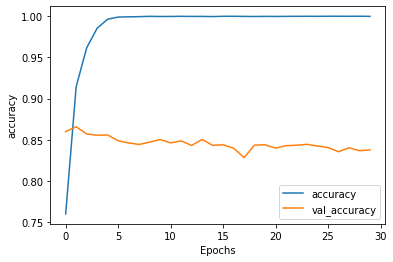

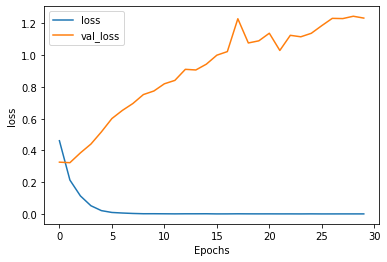

In [13]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string,"val_"+string])
  plt.show()

plot_graphs(history,'accuracy')
plot_graphs(history, 'loss')